# Stock Market Analysis and Portfolio Optimization

This project will conduct analysis on stock market and discuss about what strategies are the best to optimize our portfolio values. In the future I will be using machine learning techniques to build a model to optimize the portfolio value. Currently, this project is in an exploratory stage when I am conducting general analysis on each of the stock. 

**Important Note**: All the charts are displayed as a static image for demostrating purposes on Github. All functionalities (e.g. zooming in, showing data on hover, etc.) are **disabled** due to a PNG format. You would need to run locally if you'd like to enable these features.

In [1]:
import pandas as pd
import yfinance as yf
import time
import matplotlib.pyplot as plt
import numpy as np
import technical_indicators as ti
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import plotly.io as pio
from IPython.display import Image


In [2]:
# common methods to get daily return and to normalize the data using pandas

def get_daily_return(data):
    return data / data.shift(1) - 1

def normalize(data):
    return data / data.iloc[0]


In [3]:
stocks = yf.download('SPY NOK V GLD DIS SBUX AMD MSFT BA TMUS CVX', auto_adjust=True, period='3y') #1y, 5y
#stocks = stocks.ffill().bfill()
close = stocks['Close']
spy = close['SPY']
interested_stocks = close.drop(['SPY'], axis=1)

[*********************100%***********************]  11 of 11 completed


Note that stocks = stocks.ffill().bfill() would be needed if we were looking way back in time when a particular stock no longer exist / hadn't existed during that time. 

We begin this project be calculating the daily return for all the stocks.

In [4]:
dailyReturn = get_daily_return(interested_stocks)
dailyReturn = dailyReturn.iloc[1:, :]

dailyReturnSPY = get_daily_return(spy)
dailyReturnSPY = dailyReturnSPY.iloc[1:]

## Stocks Exploratory Analysis

Visualizing the cumulative return for all the stocks for the past three years. Note that all of them started from 1.0. If they doubled the value during the time, then their cumulative return would be 2.0. 

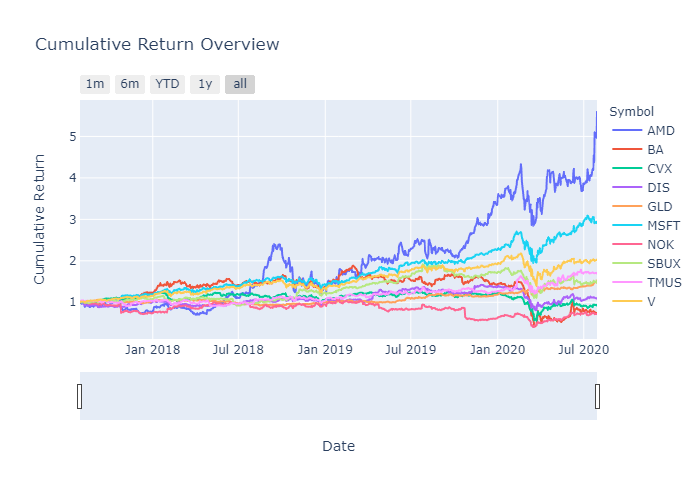

In [5]:
normalizedStocks = normalize(interested_stocks)
fig1 = px.line(normalize(interested_stocks), 
               labels={"value":"Cumulative Return", 'variable': 'Symbol'},
               title='Cumulative Return Overview' )

fig1.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")])))
fig1.show()
Image(pio.to_image(fig1, format='png'))

**Important Note**: All the charts are displayed as a static image for demostrating purposes on Github. All functionalities (e.g. zooming in, showing data on hover, etc.) are disabled due to a PNG format. You would need to run locally if you'd like to enable these features.

Please remove "Image(pio.to_image(fig1, format='png'))" if you do not need the static image. 

We can visualize the correlation between two stocks. Positive Correlation means that when stock A rises, stock B also rises. In contrast, negative corrlation means that when stock A rises, stock B falls. Note that the correlation between oneself is always 1.0.

The heatmap shown below indicates that most stocks has a moderate positive correlation (at 0.5). Specifically, GLD has a weak correlation for all other stocks; Visa (V) and Microsoft (MSFT) has a high positive correlation (>0.8).

Selecting stocks with high correlation might not be optimal for our portfolio. So we might not want to include both Visa and Microsoft.  

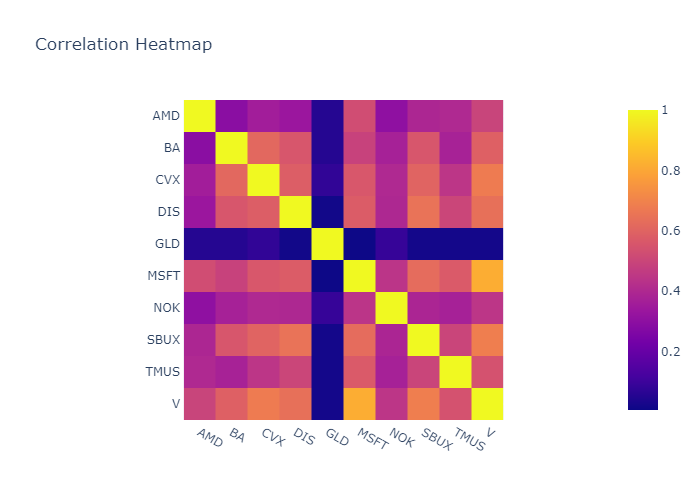

In [6]:
correlations = dailyReturn.corr()

fig = px.imshow(correlations, title='Correlation Heatmap')
fig.show()
Image(pio.to_image(fig, format='png'))

The chart below shows that the return of a stock (y-axis) and the risk associated with it (x-axis). The best spot in the top left portion of the chart, where it would have a high return but low risk. 

According to the chart, AMD has the highest return out of all stocks, but also the most risky. Microsoft (MSFT), Visa (V), T-mobile (TMUS), starbucks (SBUX), and Disney (DIS) all have a similar level of risk, but Microsoft (MSFT) has the highest return in general. As a result, if an investor were to choose a stock to invest in out of these five stocks, Microsoft would be the best out of all. 

## Portfolio Optimization

However, average investor would not solely invest in one stock. A diversified portfolio is often the most important strategy in terms of long term investment. Therefore, we need to search for the best weights for each of the stock in order to find the best position where it generates a high return while keeping the risk as minimal as possible. Therefore, efficient frontier and sharpe ratio kicks in for this purpose. 

Best weight allocation:
AMD     0.10466
BA      0.00000
CVX     0.00000
DIS     0.00000
GLD     0.64961
MSFT    0.24574
NOK     0.00000
SBUX    0.00000
TMUS    0.00000
V       0.00000
dtype: float64
Expected annual return: 27.7%
Annual volatility: 14.9%
Sharpe Ratio: 1.73


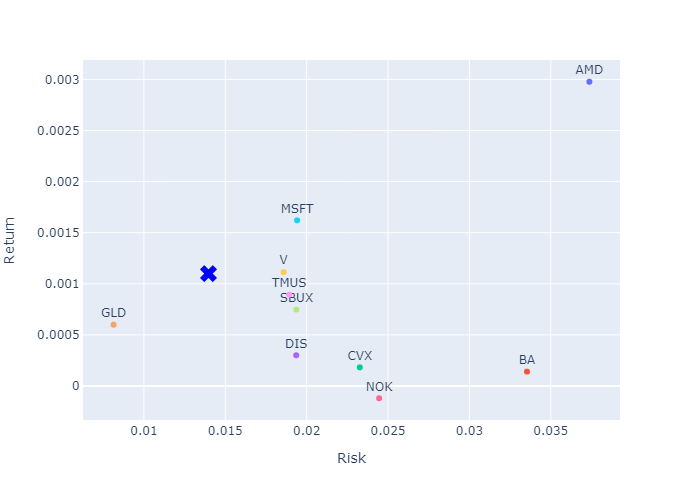

In [7]:
stds = dailyReturn.std().rename('std')
means = dailyReturn.mean().rename('mean')

fig = px.scatter(x=stds,  y=means, 
                 color=means.index, text=means.index,
                 labels={"x":"Risk", 'y': 'Return'} )

mu = expected_returns.mean_historical_return(interested_stocks, frequency=252)
S = risk_models.sample_cov(interested_stocks, frequency=252)

ef = EfficientFrontier(mu, S)
ef.max_sharpe()
w = ef.clean_weights()
w = pd.Series(w)

fig.add_trace(
    go.Scatter(
        x=[(stds * w).sum()], y=[(means * w).sum()],
        mode='markers', marker_symbol='x', marker_size=15, marker_color='blue',
        text=['Best Sharpe Ratio']
    ))

fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.show()

print ('Best weight allocation:')
print (w)
ef.portfolio_performance(verbose=True)

Image(pio.to_image(fig, format='png'))

Efficient frontier is a curve where it shows you where the highest return is given the risk level. Not that I am not showing the efficient frontier in the chart above, but showing a point of efficient frontier where it generates the highest sharpe ratio.

Sharpe Ratio is used to help investor determine the return of an investment compared to its risk. With the stocks I selected, it shows that a combination of AMD, GLD, and MSFT generate the highest Sharpe Ratio. 

Looking at the weights, we can see roughly 65% comes from GLD, 25% comes from MSFT, and 10% from AMD. It makes sense because GLD is considered a safe stock, where the return is small but the risk is also minimal. MSFT is considered a medium risky stock, but it generates a higher return than GLD. AMD, lastly, is a very risky stock as it's volatility is high. A 65%/25%/10% is a reasonable strategy for an average investor that wants a "okay" return with minimal risk.

We will continue to investigate these three stocks below. 

## Moving Average Convergence Divergence (MACD)

The first indicator I will discuss in this project is Moving Average Convergence Divergence (MACD). Moving Average Convergence Divergence (MACD) is a momentum indicator that utilize a short-term moving average (typically 12 days), a long-term moving average (typically 26 days), and a signal line in order to create a buy or a sell signal. 

Since MACD is a comparison between the short-term moving average and the long-term moving average, it can track how rapid the stock changes. When MACD crosses zeros, it generally means that there is a change of direction of the momentum. When MACD is positive, it means there is a upward momentum; when it is negative, it means the stock is heading down.

Additionally, a 9-day moving average of MACD is also plotted in order to determine when to buy or sell the stock. There is a buying opportunity when the MACD line crosses and is above the signal line; a selling opportunity when the MACD line crosses and is below the signal line.



In [8]:
bestStocks = interested_stocks[['GLD','MSFT','AMD']]
macd = ti.macd(bestStocks, 12, 26)
signal_line = macd.ewm(span=9, adjust=False, ignore_na=False).mean()


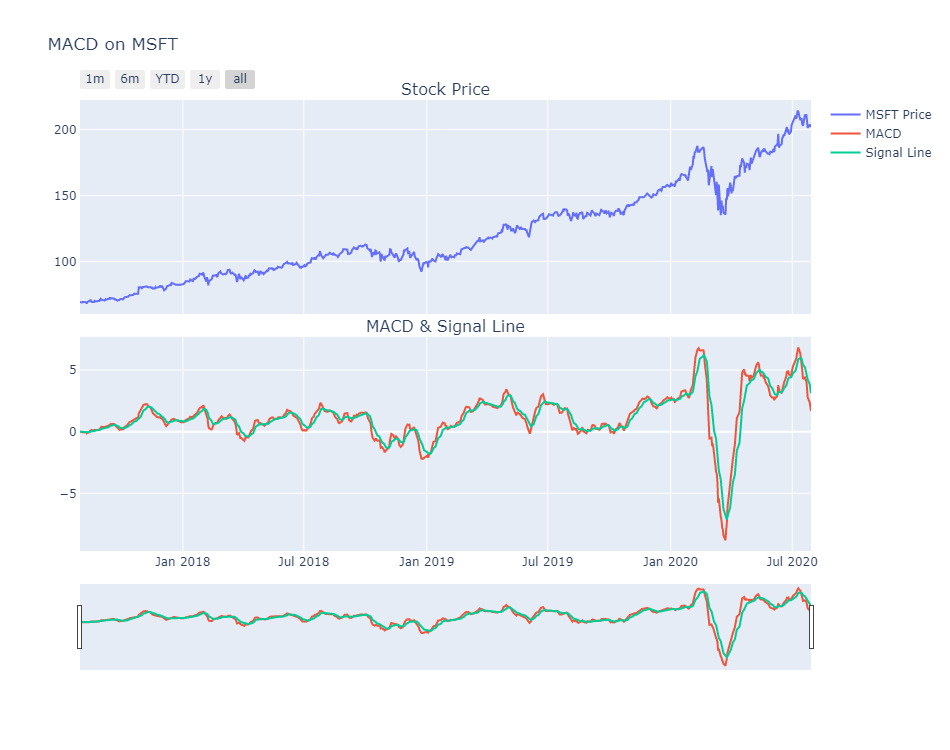

In [9]:

def plot_MACD(symbol, data, macd, signal_line):
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.05, 
                        subplot_titles=("Stock Price", "MACD & Signal Line"))

    top_plot = go.Scatter(x = data[symbol].index, y = data[symbol].values, name=symbol + " Price")

    macd_sym = macd[symbol]
    signal_sym = signal_line[symbol]
    bottom_plot_1 = go.Scatter(x = macd_sym.index, y = macd_sym.values, name='MACD')
    bottom_plot_2 = go.Scatter(x = signal_sym.index, y = signal_sym.values, name='Signal Line')

    fig.append_trace(top_plot, row=1, col=1)
    fig.append_trace(bottom_plot_1, row=2, col=1)
    fig.append_trace(bottom_plot_2, row=2, col=1)

    fig.update_layout(height=750, width=950, title_text="MACD on "+ symbol)

    fig.update_xaxes(row=2, col=1, rangeslider_visible=True)
    fig.update_xaxes(
        row=1, col=1,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    return fig

fig = plot_MACD('MSFT', bestStocks, macd, signal_line)
fig.show()
Image(pio.to_image(fig, format='png'))

## Relative Strength Index (RSI)

Relative Strength Index (RSI) is a technical indicator where it calculates the magnitude of the momentum in order to create a buy or a sell signal. RSI ranges from 0 to 100, and it typically fluctuates in between 30 and 70. 

This indicator might work because it signals when the stock is going up or down too rapidly, and believes that it would return back to the less extreme value. Generally, when the score is below 30, the stock is being oversold, or there is a buying opportunity. In contrast, if the score is above 70, it typically means a sell signal is triggered, since the stock is being overbought. 


In [10]:
rsi = ti.rsi(bestStocks, look_back_period=14)

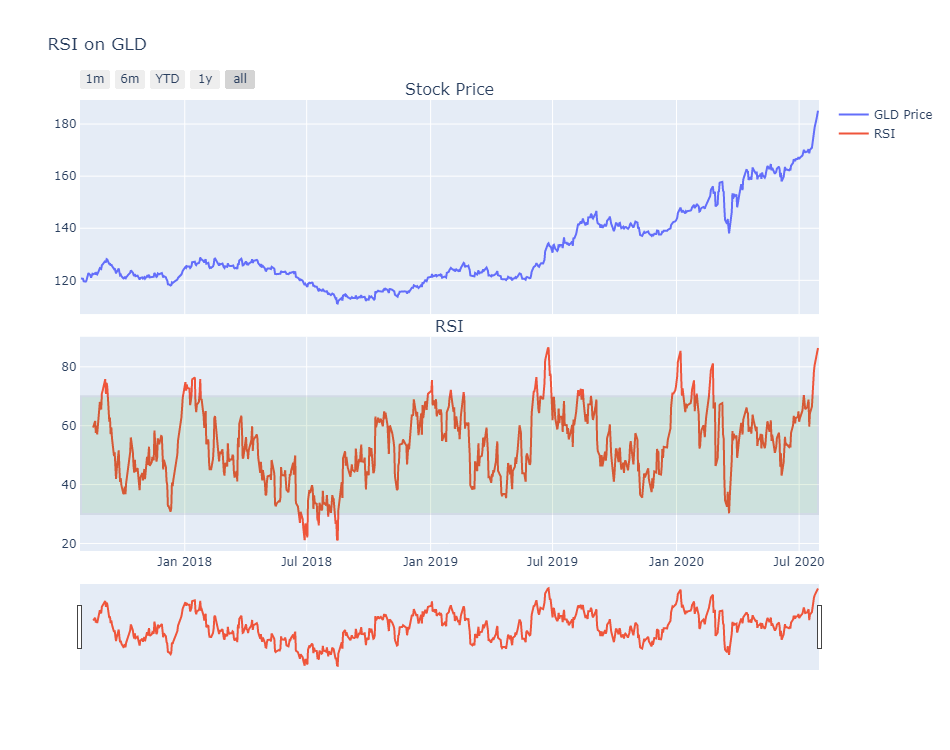

In [11]:
def plot_RSI(symbol, data, rsi):
    rsi_sym = rsi[symbol]
    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=("Stock Price", "RSI"))
    
    top_plot = go.Scatter(x=data[symbol].index, y=data[symbol].values, name=symbol +  ' Price')
    bottom_plot_1 = go.Scatter(x=rsi_sym.index, y=rsi_sym.values, name='RSI')
    fig.append_trace(top_plot, row=1, col=1)
    fig.append_trace(bottom_plot_1, row=2, col=1)
    fig.add_shape(row=2, col=1, type='rect',
                  x0=bestStocks.index [0], y0=70,
                  x1=bestStocks.index[-1], y1=30, 
                  fillcolor='green', 
                  opacity=0.1 )

    fig.update_layout(height=750, width=950, title_text="RSI on " + symbol)

    fig.update_xaxes(row=2, col=1, rangeslider_visible=True)
    fig.update_xaxes(
        row=1, col=1,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])))
    return fig
fig = plot_RSI('GLD',bestStocks, rsi)
fig.show()
Image(pio.to_image(fig, format='png'))

In [13]:
bestStocks = interested_stocks
bestStocksHigh = stocks['High']
bestStocksLow = stocks['Low']

In [14]:
adx, adx_signal = ti.adx(bestStocks, bestStocksHigh, bestStocksLow, look_back_period=14, modified_version=True)

In [15]:
symbol='GLD'
rsi_sym = adx[symbol].rolling(10).mean()
data = bestStocks

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.05,
                    subplot_titles=("Stock Price", "modified ADX"))

top_plot = go.Scatter(x=data[symbol].index, y=data[symbol].values, name=symbol + ' Price')
bottom_plot_1 = go.Scatter(x=rsi_sym.index, y=rsi_sym.values, name='ADX')

fig.append_trace(top_plot, row=1, col=1)
fig.append_trace(bottom_plot_1, row=2, col=1)
fig.add_shape(row=2, col=1, type='rect',
              x0=bestStocks.index[0], y0=25,
              x1=bestStocks.index[-1], y1=-25,
              fillcolor='green',
              opacity=0.1)

fig.update_layout(height=750, width=950, title_text="ADX on " + symbol)

fig.update_xaxes(row=2, col=1, rangeslider_visible=True)
fig.update_xaxes(
    row=1, col=1,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])))
